# Genomics Network Analysis with Leiden/Louvain Community Detection

This notebook loads a gene expression dataset, computes a correlation matrix, builds a gene co-expression network, and detects communities using the Leiden or Louvain algorithm.

In [1]:
%env NX_CUGRAPH_AUTOCONFIG=True

import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

env: NX_CUGRAPH_AUTOCONFIG=True


## Load and preprocess the gene expression data

In [21]:
%%time
# https://figshare.com/articles/dataset/Gene_expression_csv_files/21861975?file=38793663
# https://figshare.com/ndownloader/files/38793663
df = pd.read_csv("/tmp/genomics/g.csv").drop(["NAME", "Foldchange", "PValue", "FDR"], axis=1)
df

CPU times: user 62.7 ms, sys: 5.98 ms, total: 68.7 ms
Wall time: 66.4 ms


,Gene_symbol,1negH,2negH,3negH,4negH,5negH,6negH,1negN,2negN,3negN,4negN,5negN,6negN
0,0610007P14Rik,21.029999,24.146191,19.102242,20.951491,20.477456,19.736071,21.467147,20.915478,19.726746,14.117321,20.646162,19.674725
1,0610009B22Rik,12.474068,12.291472,12.133346,11.639717,11.900859,11.783808,11.868855,11.557070,13.337265,9.694298,12.153082,12.277833
2,0610009L18Rik,1.199430,1.310258,0.746667,0.440422,1.329705,1.662746,0.877263,1.183895,1.612879,1.151198,1.173077,1.459251
3,0610009O20Rik,39.461234,40.368439,39.946707,39.889625,39.292780,36.941877,46.959384,45.833649,34.738924,45.078485,47.955404,49.815800
4,0610010B08Rik,32.744429,43.612888,31.111143,22.398591,22.073102,24.796602,24.769785,38.843031,32.257572,23.508672,35.896168,43.777521
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14668,Zyg11b,135.255680,129.278834,143.173478,142.822475,139.619016,124.778238,152.282574,160.953344,108.000833,176.072686,156.441600,159.360240
14669,Zyx,231.729803,238.903791,198.489089,235.877294,207.566937,187.528824,285.781395,262.711938,225.989107,343.359914,244.469327,265.080437
14670,Zzef1,83.880111,83.107822,92.337871,81.855524,85.832452,72.799354,82.772365,82.759898,68.609375,93.974100,83.898495,86.850576
14671,Zzz3,123.181422,119.982238,129.546797,121.870984,124.659836,113.717363,111.876862,118.558628,88.025952,120.027526,113.929276,120.212066


In [22]:
%%time
df = df.transpose()
df.columns = df.iloc[0]
df = df[1:]
df

CPU times: user 12.4 ms, sys: 5.02 ms, total: 17.4 ms
Wall time: 16.2 ms


Gene_symbol,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
1negH,21.029999,12.474068,1.19943,39.461234,32.744429,29.98574,15.632566,8.036178,12.633992,62.050492,...,8.91576,45.018592,20.790113,28.706349,33.823915,135.25568,231.729803,83.880111,123.181422,16.911958
2negH,24.146191,12.291472,1.310258,40.368439,43.612888,33.380394,15.972674,9.795742,13.664124,55.904361,...,8.61027,49.103495,22.96072,30.323124,30.697484,129.278834,238.903791,83.107822,119.982238,18.780371
3negH,19.102242,12.133346,0.746667,39.946707,31.111143,34.657813,14.808904,7.528896,12.071123,57.617836,...,7.653341,44.364489,20.346687,28.497807,31.04892,143.173478,198.489089,92.337871,129.546797,15.431127
4negH,20.951491,11.639717,0.440422,39.889625,22.398591,33.094547,15.66643,9.500526,12.709313,53.102277,...,6.165904,49.704738,20.322317,29.067834,32.52829,142.822475,235.877294,81.855524,121.870984,15.603513
5negH,20.477456,11.900859,1.329705,39.29278,22.073102,30.782669,16.089429,8.310656,13.363534,48.534229,...,6.515554,47.27101,21.275279,31.04861,29.585934,139.619016,207.566937,85.832452,124.659836,15.956459
6negH,19.736071,11.783808,1.662746,36.941877,24.796602,34.483905,20.314418,9.036663,13.301967,56.316482,...,6.723277,45.906246,20.242124,25.230362,27.037695,124.778238,187.528824,72.799354,113.717363,15.253887
1negN,21.467147,11.868855,0.877263,46.959384,24.769785,30.291383,19.454602,5.366787,12.126874,52.687397,...,7.534143,29.723742,18.835357,27.19516,30.704213,152.282574,285.781395,82.772365,111.876862,22.75724
2negN,20.915478,11.55707,1.183895,45.833649,38.843031,35.009466,17.871177,7.216122,10.655055,57.390719,...,8.569145,28.300728,17.251041,32.359797,28.526232,160.953344,262.711938,82.759898,118.558628,20.182591
3negN,19.726746,13.337265,1.612879,34.738924,32.257572,25.68199,30.644694,9.987441,17.49353,53.473129,...,9.429136,27.108767,25.806058,27.729105,27.418936,108.000833,225.989107,68.609375,88.025952,16.749124
4negN,14.117321,9.694298,1.151198,45.078485,23.508672,29.082894,20.115668,6.422472,10.906085,46.714398,...,9.694298,30.537038,22.721011,37.747172,25.083996,176.072686,343.359914,93.9741,120.027526,18.782702


In [23]:
%%time
cm = df.corr()
print(f"correlation matrix shape: {cm.shape}")
cm

correlation matrix shape: (14673, 14673)
CPU times: user 6.32 s, sys: 206 ms, total: 6.52 s
Wall time: 6.52 s


Gene_symbol,0610007P14Rik,0610009B22Rik,0610009L18Rik,0610009O20Rik,0610010B08Rik,0610010F05Rik,0610010K14Rik,0610011F06Rik,0610012G03Rik,0610030E20Rik,...,Zwilch,Zwint,Zxda,Zxdb,Zxdc,Zyg11b,Zyx,Zzef1,Zzz3,l7Rn6
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,1.000000,0.654730,-0.032898,-0.115824,0.413583,0.307951,-0.254081,0.340229,0.251359,0.437785,...,-0.231645,0.342763,-0.159523,-0.548745,0.631587,-0.461406,-0.478918,-0.373224,-0.010052,0.103632
0610009B22Rik,0.654730,1.000000,0.273219,-0.356026,0.414474,-0.159859,0.277730,0.446222,0.737879,0.553768,...,-0.105149,0.045430,0.221927,-0.737408,0.442109,-0.744975,-0.651684,-0.595764,-0.428483,-0.072699
0610009L18Rik,-0.032898,0.273219,1.000000,-0.175571,0.319760,-0.285220,0.536650,0.242670,0.471021,0.121091,...,0.170069,-0.248465,0.331362,-0.121872,-0.521899,-0.356649,-0.154415,-0.479709,-0.473448,0.036256
0610009O20Rik,-0.115824,-0.356026,-0.175571,1.000000,0.345184,0.196113,-0.280649,-0.801039,-0.585589,0.163544,...,-0.131129,-0.587087,-0.565516,0.353836,-0.038328,0.849004,0.643119,0.533064,0.268170,0.881709
0610010B08Rik,0.413583,0.414474,0.319760,0.345184,1.000000,0.203992,-0.032472,0.064455,0.086956,0.683210,...,0.143470,-0.277693,-0.071530,-0.027865,0.142927,0.012628,0.012431,0.006088,-0.032395,0.456834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zyg11b,-0.461406,-0.744975,-0.356649,0.849004,0.012628,0.226686,-0.407689,-0.793181,-0.828120,-0.137014,...,-0.021179,-0.402780,-0.532013,0.673214,-0.168878,1.000000,0.735252,0.771263,0.496100,0.566039
Zyx,-0.478918,-0.651684,-0.154415,0.643119,0.012431,-0.320090,0.101023,-0.588062,-0.445688,-0.351882,...,0.381059,-0.577267,-0.054756,0.709816,-0.339104,0.735252,1.000000,0.448430,-0.018865,0.606892
Zzef1,-0.373224,-0.595764,-0.479709,0.533064,0.006088,0.245707,-0.660804,-0.565687,-0.733372,-0.118555,...,-0.012564,0.042401,-0.307789,0.624758,0.121754,0.771263,0.448430,1.000000,0.784901,0.195851


In [24]:
cm = cm.to_numpy()
(num_rows, num_cols) = cm.shape
col_names = df.columns.tolist()
del df

## Build the network from the correlation matrix

In [5]:
%%time
edges = np.empty((num_rows * num_cols, 3), dtype=object)
edgeno = 0
edge_indices = [(i, j) for i in range(num_rows) for j in range(num_cols) if i != j]
for i, j in tqdm(edge_indices, desc="Processing edges"):
    weight = abs(cm[i, j])
    if weight > 0.5: # Set a threshold for significance
        edges[edgeno] = (col_names[i], col_names[j], weight)
        edgeno += 1
# Convert to a Pandas DataFrame with correct column names and dtypes for easy conversion to a NetworkX Graph.
edges = pd.DataFrame(edges[:edgeno], columns=["source", "target", "weight"])
edges = edges.astype({"source": str, "target": str, "weight": float})

Processing edges: 100%|███████████████████████████████████████████| 215282256/215282256 [02:19<00:00, 1545597.52it/s]


CPU times: user 2min 38s, sys: 10.2 s, total: 2min 48s
Wall time: 2min 48s


In [6]:
%%time
G = nx.from_pandas_edgelist(edges, edge_attr="weight")
print(f"graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

del cm, col_names, edges, edge_indices

graph has 14673 nodes and 83824080 edges
CPU times: user 2min 50s, sys: 4.88 s, total: 2min 55s
Wall time: 2min 53s


## Community detection (Leiden or Louvain)

In [7]:
%%time
try:
    communities = nx.community.leiden_communities(G)
except NotImplementedError:
    print("leiden not available (is the cugraph backend enabled?), using louvain.")
    communities = nx.community.louvain_communities(G)

num_communities = len(communities)
print(f"Number of communities: {num_communities}")

Number of communities: 4
CPU times: user 3.45 s, sys: 539 ms, total: 3.99 s
Wall time: 3.96 s


In [8]:
%%time
# Use a colormap with enough distinct colors
if num_communities <= 10:
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf", "#d62728"]
else:
    cmap = plt.get_cmap("hsv")
    colors = [cmap(i / num_communities) for i in range(num_communities)]

# Map node to its community color
node_colors = {}
for i, comm in enumerate(communities):
    for node in comm:
        node_colors[node] = colors[i]

# Set the color attribute for each node in G
nx.set_node_attributes(G, node_colors, "color")

CPU times: user 2min 25s, sys: 8.09 s, total: 2min 33s
Wall time: 2min 33s


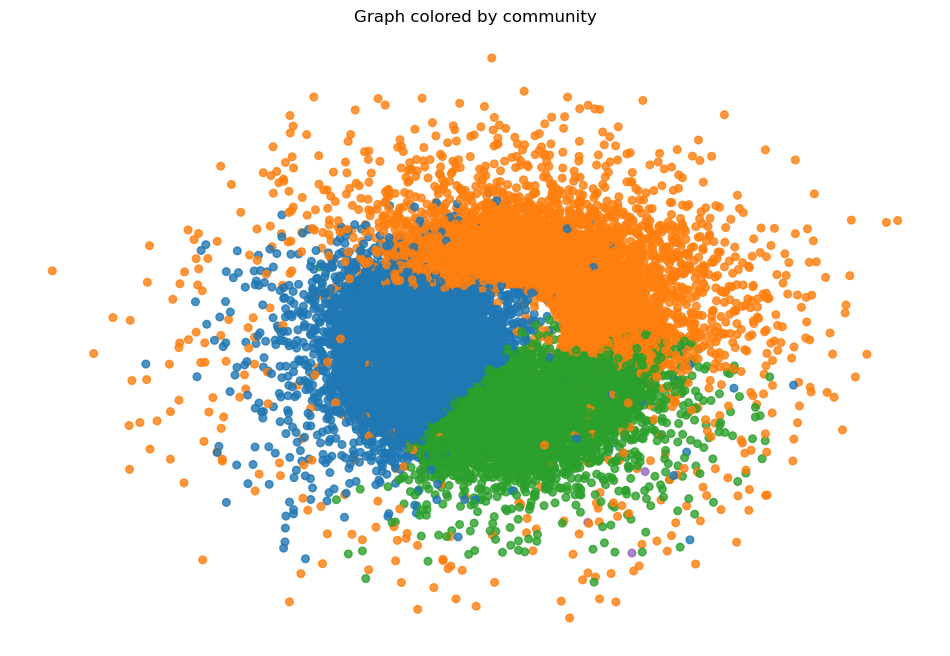

CPU times: user 19min 16s, sys: 1min 50s, total: 21min 7s
Wall time: 20min 11s


In [9]:
%%time
# Draw the graph using the color attribute
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, seed=42)  # deterministic layout for reproducibility
node_colors = [G.nodes[n].get("color", "#333333") for n in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=30, alpha=0.8)
#nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5)
plt.axis("off")
plt.title("Graph colored by community")
plt.show()